In [1]:
%config InlineBackend.figure_format = 'svg' 
# 如果要保存svg格式图片，可以用上面的命令

import os
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# %matplotlib inline

# plt.style.use("ggplot")

读取临床病理信息

In [2]:
clinical_info = pd.read_csv("/mnt/DATA/TJMUCH_data_total/70genes_clinicalinfo_full_1202_OK.csv")
print(clinical_info.columns)
use_info = clinical_info.loc[:, ["slide_id", "初诊年龄", "ER数值\t", "PR数值\t", "Ki67\t", "P53数值\t",
                                 "HER2\t", "HER2status", "MMPrisk", "MMP_index"]]
use_info.rename(columns={'初诊年龄':'age', 'ER数值\t':'ER', 'PR数值\t':'PR', 'Ki67\t': 'Ki67',
                         'P53数值\t': 'P53', 'HER2\t': 'HER2score'}, inplace = True)

use_info = use_info.replace("Unknown", np.nan)
use_info = use_info[pd.notna(use_info["MMPrisk"])]
# use_info = use_info.dropna(inplace=False)

use_info["MMP_index"] = use_info["MMP_index"].astype(float)

use_info["age"] = use_info["age"].astype(int)


use_info

Index(['case_id', 'slide_id', '性别', '初诊年龄', '婚姻状况', '民族', '入院日期', '入院前发现时长',
       '是否生育', '初产年龄', '末胎年龄', '怀孕次数', '足月产次数', '流产和或早产次数', '是否母乳喂养', '哺乳侧别',
       '哺乳时长', '是否有系统疾病（高血压，心脏病，糖尿病，等……）', '具体系统疾病', '是否有乳腺良性手术史', '具体乳腺病史',
       '是否有恶性肿瘤既往史', '具体恶性肿瘤既往史', '是否有恶性肿瘤家族史', '具体恶性肿瘤家族史', '乳腺癌家族史',
       '具体乳腺癌家族史情况', '卵巢癌家族史', '具体卵巢癌家族史情况', '其他恶性肿瘤家族史', '手术日期\t', '手术方式\t',
       '是否全切', '是否保乳\t', '是否再造\t', '肿瘤位置（左、右、双）', '临床TNM分期\t', '病理学分期\t',
       'T分期', 'N分期', 'M分期', '病理类型\t', '病理具体描述', '组织学分级\t', '淋巴管癌栓',
       '间质内浸润淋巴细胞', '腋窝淋巴结总数\t', '阳性腋窝淋巴结数\t', 'ER数值\t', 'ER强度', 'PR数值\t',
       'PR强度', 'HER2\t', 'Ki67\t', 'P53数值\t', 'P53强度', 'FISH',
       'HER2-FISH COPY数', 'HER2-FISH RATIO', 'HER2status', 'MMPrisk',
       'MMP_index', '对应治疗', 'Unnamed: 63'],
      dtype='object')


,slide_id,age,ER,PR,Ki67,P53,HER2score,HER2status,MMPrisk,MMP_index
0,1001,28,90%,40%,15%,不详,0,Negative,High,-0.184
1,1002,46,95%,95%,20-25%,< 5%,1+,Negative,Low,0.223
2,1003,32,90%,90%,30%,不详,1+,Negative,Low,0.145
3,1004,44,90%,90%,15%～20%,1%,2+,Negative,Low,0.395
4,1006,48,90%,90%,10%,< 1%,1+,Negative,High,-0.240
...,...,...,...,...,...,...,...,...,...,...
483,6046,48,80%,70%,10%,1%,-,NaN,Low,0.343
484,6047,48,80%,70%,15%～20%,1%,-,NaN,Low,0.232
485,6048,73,90%,90%,20%,< 1%,-,NaN,Low,0.549
486,6049,61,60%,5%,30%,60%,-,NaN,High,-0.420


下面代码是直接读取五次csv文件，在dataframe中mean prob值，然后只做一次临床数据评估，结果 87/161

In [9]:
# exp_name = "new_PhiTrans_align_sim_tile5ktwice500"
exp_name = "new_PhiTrans_tileAll_twice1000_0abmil_0sel"
root_path = "/home/cyyan/Projects/HER2proj/models/Yale/HER2status"

filename = "eval_TJMUCH70genes_res.csv"


pred_info = pd.DataFrame()
# for idx in range(5):
#     indep_val_res = pd.read_csv(os.path.join(root_path, exp_name, f"time{idx}", filename))
#     pred_info = pd.concat([pred_info, indep_val_res.pred], axis=1)
# indep_val_res.pred = pred_info.mode(1) # majority mode

neg_info = pd.DataFrame()
pos_info = pd.DataFrame()
for idx in range(5):
    indep_val_res = pd.read_csv(os.path.join(root_path, exp_name, f"time{idx}", filename))
    neg_info = pd.concat([neg_info, indep_val_res.prob_neg], axis=1)
    pos_info = pd.concat([pos_info, indep_val_res.prob_pos], axis=1)

indep_val_res.prob_neg = neg_info.mean(1) # majority mode
indep_val_res.prob_pos = pos_info.mean(1) # majority mode

indep_val_res.pred = np.argmax(np.array([neg_info.mean(1), pos_info.mean(1)]), axis=0)


交集融合预测到的样本和临床信息数据

In [10]:
# 显示所有列
pd.set_option('display.max_columns', 20)
# 显示所有行
pd.set_option('display.max_rows', 10)

common_data = pd.merge(indep_val_res, use_info,how='inner',on='slide_id').iloc[:, 1:]
common_data

,slide_id,prob_neg,prob_pos,pred,label,sim0,sim1,sim2,sim3,sim4,...,sim8,age,ER,PR,Ki67,P53,HER2score,HER2status,MMPrisk,MMP_index
0,1001,0.164395,0.835605,1,0,0.095079,0.645240,0.153385,0.352492,0.280618,...,0.372318,28,90%,40%,15%,不详,0,Negative,High,-0.184
1,1002,0.441190,0.558810,1,0,0.014710,0.100420,0.023801,0.054571,0.043461,...,0.058029,46,95%,95%,20-25%,< 5%,1+,Negative,Low,0.223
2,1003,0.634044,0.365956,0,0,-0.009554,-0.064020,-0.015366,-0.035482,-0.028574,...,-0.036609,32,90%,90%,30%,不详,1+,Negative,Low,0.145
3,1004,0.361126,0.638874,1,0,0.072814,0.492989,0.117140,0.269164,0.214330,...,0.284455,44,90%,90%,15%～20%,1%,2+,Negative,Low,0.395
4,1006,0.212020,0.787980,1,0,0.059980,0.407510,0.096938,0.222020,0.176557,...,0.235274,48,90%,90%,10%,< 1%,1+,Negative,High,-0.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,4016,0.557062,0.442938,0,0,-0.078845,-0.535936,-0.127719,-0.292934,-0.232817,...,-0.309009,48,90%,90%,15%,5%,0,Negative,Low,0.251
252,4017,0.655608,0.344392,0,0,-0.042561,-0.289030,-0.069208,-0.157388,-0.125338,...,-0.166968,38,80%,70%,5%,10%,1+,Negative,High,-0.053
253,4018,0.611092,0.388908,0,0,-0.089477,-0.608261,-0.145111,-0.331873,-0.263926,...,-0.350630,48,85%,20%,5%,1%,1+,Negative,Low,0.483
254,4019,0.609009,0.390991,0,0,-0.059524,-0.405021,-0.096659,-0.221122,-0.175853,...,-0.233716,52,80%,90%,10%,< 1%,0,Negative,Low,0.450


根据 her2 status 的预测prob和MMP的index进行关联

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import auc as calc_auc
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score, roc_curve, precision_recall_curve


neg_data = common_data[common_data['label'] == 0]

print(sum(neg_data.label == neg_data.pred))


auc = roc_auc_score(common_data['label'], common_data['prob_pos'])
# print(auc)
res_dict = classification_report(neg_data['label'], neg_data['pred'], 
                                    target_names=['neg', 'pos'], output_dict=True)
# print(auc)
print(res_dict['neg'])
# res_dict

43
{'precision': 1.0, 'recall': 0.16996047430830039, 'f1-score': 0.29054054054054057, 'support': 253.0}


/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# exp_name = "new_PhiTrans_align_sim_tile5ktwice500"

filename = "eval_TJMUCH70genes_res.csv"


for idx in range(4):
    indep_val_res = pd.read_csv(os.path.join(root_path, exp_name, f"time{idx}", filename))
    
    common_data = pd.merge(indep_val_res, use_info, how='inner',on='slide_id').iloc[:, 1:]
    
    neg_data = common_data[common_data['label'] == 0]

    print(sum(neg_data.label == neg_data.pred))

    auc = roc_auc_score(common_data['label'], common_data['prob_pos'])
    # print(auc)
    res_dict = classification_report(neg_data['label'], neg_data['pred'], 
                                        target_names=['neg', 'pos'], output_dict=True)
    # print(auc)
    print(res_dict['neg'])
    # res_dict


162
{'precision': 1.0, 'recall': 0.6403162055335968, 'f1-score': 0.7807228915662651, 'support': 253.0}
114
{'precision': 1.0, 'recall': 0.4505928853754941, 'f1-score': 0.6212534059945504, 'support': 253.0}
5
{'precision': 1.0, 'recall': 0.019762845849802372, 'f1-score': 0.03875968992248062, 'support': 253.0}
79
{'precision': 1.0, 'recall': 0.31225296442687744, 'f1-score': 0.4759036144578313, 'support': 253.0}


/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cyyan/anacond

In [14]:
common_data

,slide_id,prob_neg,prob_pos,pred,label,sim0,sim1,sim2,sim3,sim4,...,sim10,age,ER,PR,Ki67,P53,HER2score,HER2status,MMPrisk,MMP_index
0,1001,0.260176,0.739824,1,0,0.073363,0.100217,0.050942,-0.116556,0.099046,...,0.106929,28,90%,40%,15%,不详,0,Negative,High,-0.184
1,1002,0.730030,0.269970,0,0,-0.093443,-0.127255,-0.064932,0.148353,-0.125818,...,-0.135340,46,95%,95%,20-25%,< 5%,1+,Negative,Low,0.223
2,1003,0.729758,0.270242,0,0,-0.093425,-0.127206,-0.064838,0.147772,-0.125397,...,-0.135064,32,90%,90%,30%,不详,1+,Negative,Low,0.145
3,1004,0.779721,0.220279,0,0,-0.114957,-0.156564,-0.080097,0.181651,-0.154345,...,-0.166266,44,90%,90%,15%～20%,1%,2+,Negative,Low,0.395
4,1006,0.173431,0.826569,1,0,0.127293,0.173215,0.088302,-0.201136,0.171568,...,0.184682,48,90%,90%,10%,< 1%,1+,Negative,High,-0.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,4016,0.142628,0.857372,1,0,0.153991,0.210269,0.106885,-0.244010,0.207749,...,0.223802,48,90%,90%,15%,5%,0,Negative,Low,0.251
252,4017,0.421402,0.578598,1,0,0.008049,0.010812,0.005512,-0.012747,0.010762,...,0.012269,38,80%,70%,5%,10%,1+,Negative,High,-0.053
253,4018,0.173217,0.826783,1,0,0.126933,0.173554,0.088260,-0.201730,0.171659,...,0.184885,48,85%,20%,5%,1%,1+,Negative,Low,0.483
254,4019,0.261893,0.738107,1,0,0.072410,0.098941,0.050383,-0.115270,0.098012,...,0.105519,52,80%,90%,10%,< 1%,0,Negative,Low,0.450


/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 65374 (\N{FULLWIDTH TILDE}) missing from current font.
  fig.canvas.draw()


/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 65374 (\N{FULLWIDTH TILDE}) missing from current font.
  func(*args, **kwargs)
/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65374 (\N{FULLWIDTH TILDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


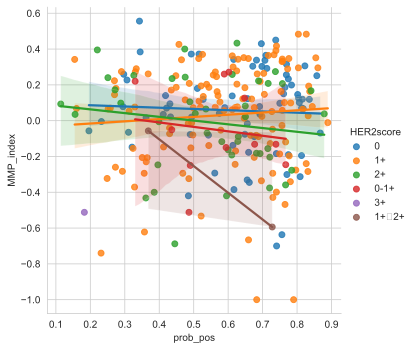

In [15]:
sns.set_style("whitegrid")
plot_data = common_data[common_data['HER2score'] == 0]

# sns.set_context("paper")
sns.lmplot(x="prob_pos", y="MMP_index", hue="HER2score",data=common_data) #, markers=["o", "*"]

/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Glyph 65374 (\N{FULLWIDTH TILDE}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)


/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 65374 (\N{FULLWIDTH TILDE}) missing from current font.
  func(*args, **kwargs)
/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65374 (\N{FULLWIDTH TILDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


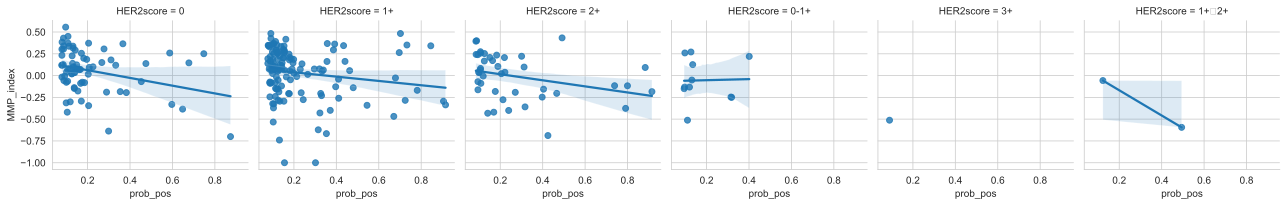

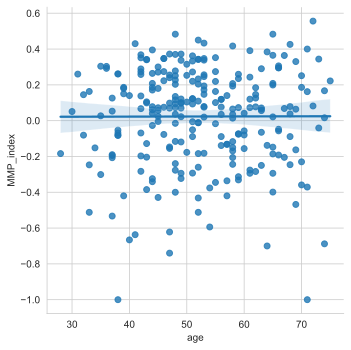

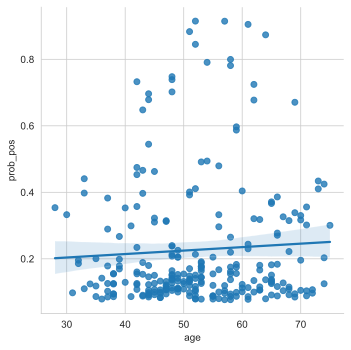

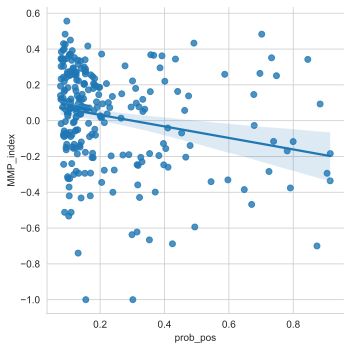

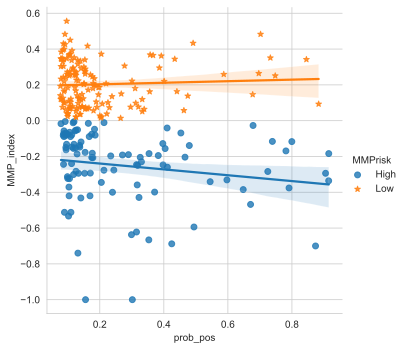

In [20]:
"""
线性回归图  lmplot   或者 regplot
"""

sns.set_style("whitegrid")

sns.lmplot(
    data=common_data, x="prob_pos", y="MMP_index",
    col="HER2score", height=3,
)

# 单一分组参数
sns.lmplot(x="age", y="MMP_index", data=common_data)

# 单一分组参数
sns.lmplot(x="age", y="prob_pos", data=common_data)

sns.lmplot(x="prob_pos", y="MMP_index", data=common_data)

# 分组的线性回归图，hue参数控制分类属性
sns.lmplot(x="prob_pos", y="MMP_index", hue="MMPrisk", markers=["o", "*"],data=common_data)

# col+hue 双分组参数，既分组，又分子图绘制
# 同时控制axes 列数，及 size 尺寸
# sn.lmplot(x="prob_pos", y="MMP_index", col="MMPrisk", hue="MMPrisk",
#                 data=common_data, col_wrap=2)
# plt.savefig("lmplot3.png", dpi=600)

